In [ ]:
# import numpy as np
# import random
# import gym
# from gym import spaces

# class MultiAgentSweepingEnv(gym.Env):
#     def __init__(self, grid_size=5, n_agents=3, n_walls=6):
#         super(MultiAgentSweepingEnv, self).__init__()
#         self.grid_size = grid_size
#         self.n_agents = n_agents
#         self.n_walls = n_walls

#         # Define action and observation space
#         self.action_space = spaces.Discrete(4)  # 0: Up, 1: Down, 2: Left, 3: Right
#         self.observation_space = spaces.Box(low=0, high=1, shape=(grid_size, grid_size, 2), dtype=np.int32)

#         # Initialize the environment
#         self.grid = np.zeros((grid_size, grid_size), dtype=int)
#         self.sweeped_cells = np.zeros((self.n_agents, grid_size, grid_size), dtype=int)
#         self.reset()

#     def reset(self):
#         # Clear the grid and place walls
#         self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
#         self.sweeped_cells = np.zeros((self.n_agents, self.grid_size, self.grid_size), dtype=int)
#         for _ in range(self.n_walls):
#             wall_x, wall_y = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
#             self.grid[wall_x, wall_y] = -1  # -1 represents a wall

#         # Initialize agents' positions
#         self.agent_positions = []
#         for _ in range(self.n_agents):
#             while True:
#                 pos = [random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)]
#                 if self.grid[pos[0], pos[1]] == 0:  # Ensure not placing agent on a wall
#                     self.agent_positions.append(pos)
#                     self.grid[pos[0], pos[1]] = 1  # Mark the position as covered by agent
#                     self.sweeped_cells[_][pos[0], pos[1]] = 1  # Mark as swept by this agent
#                     break

#         return self.get_observation()

#     def get_observation(self):
#         obs = np.zeros((self.grid_size, self.grid_size, 2), dtype=int)
#         obs[:, :, 0] = self.grid  # The grid with walls and cleaned cells
#         for pos in self.agent_positions:
#             obs[pos[0], pos[1], 1] = 1  # Mark agent positions on the second channel
#         return obs

#     def step(self, actions):
#         rewards = np.full(self.n_agents, -0.1)  # Default reward of -0.1 for no motion
#         next_positions = self.agent_positions.copy()

#         for i, action in enumerate(actions):
#             if action == 0 and self.agent_positions[i][0] > 0:  # Up
#                 next_positions[i][0] -= 1
#             elif action == 1 and self.agent_positions[i][0] < self.grid_size-1:  # Down
#                 next_positions[i][0] += 1
#             elif action == 2 and self.agent_positions[i][1] > 0:  # Left
#                 next_positions[i][1] -= 1
#             elif action == 3 and self.agent_positions[i][1] < self.grid_size-1:  # Right
#                 next_positions[i][1] += 1
#             else:
#                 rewards[i] -= 0.5  # Penalty for attempting to move out of bounds

#             # Check for collisions with walls
#             if self.grid[next_positions[i][0], next_positions[i][1]] == -1:
#                 next_positions[i] = self.agent_positions[i]  # Revert to previous position
#                 rewards[i] -= 0.5  # Penalty for colliding with a wall

#             # Check if sweeping an already swept cell
#             elif self.grid[next_positions[i][0], next_positions[i][1]] == 1:
#                 rewards[i] -= 0.05  # Penalty for sweeping an already swept cell

#             # Check for new cell being swept
#             elif self.grid[next_positions[i][0], next_positions[i][1]] == 0:
#                 rewards[i] += 1  # Reward for sweeping a new cell
#                 self.grid[next_positions[i][0], next_positions[i][1]] = 1  # Mark as visited
#                 self.sweeped_cells[i][next_positions[i][0], next_positions[i][1]] = 1  # Mark as swept by this agent

#         self.agent_positions = next_positions

#         # Check if all cells are covered
#         done = np.all(self.grid != 0)
#         if done:
#             rewards += 200  # Big reward for sweeping all cells

#         return self.get_observation(), rewards, done, {}

#     def render(self):
#         display_grid = np.full((self.grid_size, self.grid_size), '.', dtype=str)

#         # Mark walls
#         display_grid[self.grid == -1] = '#'

#         # Mark swept cells by each robot
#         for i in range(self.n_agents):
#             for x in range(self.grid_size):
#                 for y in range(self.grid_size):
#                     if self.sweeped_cells[i, x, y] == 1:
#                         display_grid[x, y] = str(i + 2)  # Use 2, 3, 4... to represent each robot's swept cells

#         # Mark current agent positions
#         for i, pos in enumerate(self.agent_positions):
#             display_grid[pos[0], pos[1]] = f'R{i+1}'  # Mark agent positions with R1, R2, R3...

#         for row in display_grid:
#             print(' '.join(row))
#         print("\n")


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

class MultiAgentSweepingEnv(gym.Env):
    """

    Attributes:
      grid_size:
      n_agents:
      n_walls:
      action_space:
      observation_space:
      grid:
      sweeped_cells:
      wall_positions:
      initial_positions:
      agent_positions:
    """
    def __init__(self, grid_size=6, n_agents=3, n_walls=8):
        super(MultiAgentSweepingEnv, self).__init__()
        self.grid_size = grid_size
        self.n_agents = n_agents
        self.n_walls = n_walls

        # Define action and observation space
        self.action_space = spaces.Discrete(4)  # 0: Up, 1: Down, 2: Left, 3: Right
        self.observation_space = spaces.Box(low=0, high=1, shape=(grid_size, grid_size, 2), dtype=np.int32)

        # Initialize the environment
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        self.sweeped_cells = np.zeros((self.n_agents, grid_size, grid_size), dtype=int)

        # Fixed wall layout and initial positions generation
        self.wall_positions = self.generate_walls()
        self.initial_positions = self.generate_initial_positions()
        self.reset_grid_with_walls()

    def generate_walls(self):
        wall_positions = []
        while len(wall_positions) < self.n_walls:
            wall_x, wall_y = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
            if (wall_x, wall_y) not in wall_positions:
                wall_positions.append((wall_x, wall_y))
        return wall_positions

    def generate_initial_positions(self):
        initial_positions = []
        while len(initial_positions) < self.n_agents:
            pos_x, pos_y = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
            if (pos_x, pos_y) not in self.wall_positions and (pos_x, pos_y) not in initial_positions:
                initial_positions.append([pos_x, pos_y])
        return initial_positions

    def reset_grid_with_walls(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        for wall in self.wall_positions:
            self.grid[wall[0], wall[1]] = -1  # -1 represents a wall

    def reset(self):
        # Clear the grid and place walls
        self.reset_grid_with_walls()
        self.sweeped_cells = np.zeros((self.n_agents, self.grid_size, self.grid_size), dtype=int)

        # Set agents' positions to the fixed initial positions
        self.agent_positions = []
        for i in range(self.n_agents):
            pos = self.initial_positions[i]
            self.agent_positions.append(pos)
            self.grid[pos[0], pos[1]] = 1  # Mark the position as covered by agent
            self.sweeped_cells[i][pos[0], pos[1]] = 1  # Mark as swept by this agent

        return self.get_observation()

    def get_observation(self):
        obs = np.zeros((self.grid_size, self.grid_size, 2), dtype=int)
        obs[:, :, 0] = self.grid  # The grid with walls and cleaned cells
        for pos in self.agent_positions:
            obs[pos[0], pos[1], 1] = 1  # Mark agent positions on the second channel
        return obs

    def step(self, actions):
        rewards = np.full(self.n_agents, -0.1)  # Default reward of -0.1 for no motion
        next_positions = self.agent_positions.copy()

        for i, action in enumerate(actions):
            if action == 0 and self.agent_positions[i][0] > 0:  # Up
                next_positions[i][0] -= 1
            elif action == 1 and self.agent_positions[i][0] < self.grid_size-1:  # Down
                next_positions[i][0] += 1
            elif action == 2 and self.agent_positions[i][1] > 0:  # Left
                next_positions[i][1] -= 1
            elif action == 3 and self.agent_positions[i][1] < self.grid_size-1:  # Right
                next_positions[i][1] += 1
            else:
                rewards[i] -= 0.5  # Penalty for attempting to move out of bounds

            # Check for collisions with walls
            if self.grid[next_positions[i][0], next_positions[i][1]] == -1:
                next_positions[i] = self.agent_positions[i]  # Revert to previous position
                rewards[i] -= 0.5  # Penalty for colliding with a wall

            # Check if sweeping an already swept cell
            elif self.grid[next_positions[i][0], next_positions[i][1]] == 1:
                rewards[i] -= 0.05  # Penalty for sweeping an already swept cell

            # Check for new cell being swept
            elif self.grid[next_positions[i][0], next_positions[i][1]] == 0:
                rewards[i] += 1  # Reward for sweeping a new cell
                self.grid[next_positions[i][0], next_positions[i][1]] = 1  # Mark as visited
                self.sweeped_cells[i][next_positions[i][0], next_positions[i][1]] = 1  # Mark as swept by this agent

        self.agent_positions = next_positions

        # Check if all cells are covered
        done = np.all(self.grid != 0)
        if done:
            rewards += 200  # Big reward for sweeping all cells

        return self.get_observation(), rewards, done, {}

    def render(self):
        display_grid = np.full((self.grid_size, self.grid_size), '.', dtype=str)

        # Mark walls
        display_grid[self.grid == -1] = '#'

        # Mark swept cells by each robot
        for i in range(self.n_agents):
            for x in range(self.grid_size):
                for y in range(self.grid_size):
                    if self.sweeped_cells[i, x, y] == 1:
                        display_grid[x, y] = str(i + 2)  # Use 2, 3, 4... to represent each robot's swept cells

        # Mark current agent positions
        for i, pos in enumerate(self.agent_positions):
            display_grid[pos[0], pos[1]] = f'R{i+1}'  # Mark agent positions with R1, R2, R3...

        for row in display_grid:
            print(' '.join(row))
        print("\n")

# Continue with the training loop from previous code


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class Agent:
    def __init__(self, grid_size, output_dim):
        input_dim = grid_size * grid_size * 2  # Flattened grid input with two channels
        self.model = DQN(input_dim, output_dim)
        self.target_model = DQN(input_dim, output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(4)  # Random action: Up, Down, Left, Right
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values, dim=1).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)

            # Get predicted Q-values for current state
            q_values = self.model(state)

            # Get Q-values for next state from the target model
            with torch.no_grad():
                next_q_values = self.target_model(next_state)

            # Compute the target Q-value
            target = q_values.clone()
            if done:
                target[0][action] = reward
            else:
                max_next_q_value = torch.max(next_q_values).item()
                target[0][action] = reward + self.gamma * max_next_q_value

            # Compute loss
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(q_values, target)
            loss.backward()
            self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


Episode 1/200, Total Rewards: [194.3  183.4  183.55], Moves: [62. 62. 62.]
4 4 # 3 2 R
4 # 2 2 # 2
2 2 4 2 # 2
2 2 R # 2 #
# R # 2 3 3
3 3 3 3 3 2


Episode 2/200, Total Rewards: [161.15 153.8  165.2 ], Moves: [131. 131. 131.]
4 4 # R 3 3
4 # 4 3 # 3
4 2 2 3 R 3
2 4 4 # 3 #
# 2 # 2 2 2
4 4 4 2 2 R


Episode 3/200, Total Rewards: [160.05 172.05 168.55], Moves: [109. 109. 109.]
4 4 # 4 4 2
4 # R 3 # 2
4 4 4 3 2 2
4 3 4 # 3 #
# 3 # 3 3 2
R R 3 3 3 3


Episode 4/200, Total Rewards: [143.25 148.2  165.15], Moves: [130. 130. 130.]
4 4 # 2 2 R
4 # 2 2 # 2
4 4 4 4 # 3
4 4 R # 3 #
# 3 # 4 3 3
4 3 4 3 R 3


Episode 5/200, Total Rewards: [150.7  142.05 143.95], Moves: [135. 135. 135.]
4 R # 2 2 2
4 # 2 2 # 2
4 4 4 R # 2
R 4 4 # 2 #
# 3 # 3 2 2
3 3 3 3 3 2


Episode 6/200, Total Rewards: [-203.4  -180.35 -193.05], Moves: [500. 500. 500.]
2 3 # 2 2 2
4 R 4 2 # R
2 3 2 2 # 3
4 4 4 # 4 #
# 3 # 4 3 3
. 3 3 4 R 3


Episode 7/200, Total Rewards: [156.75 170.4  167.7 ], Moves: [106. 106. 106.]
R 4 # 4 4 

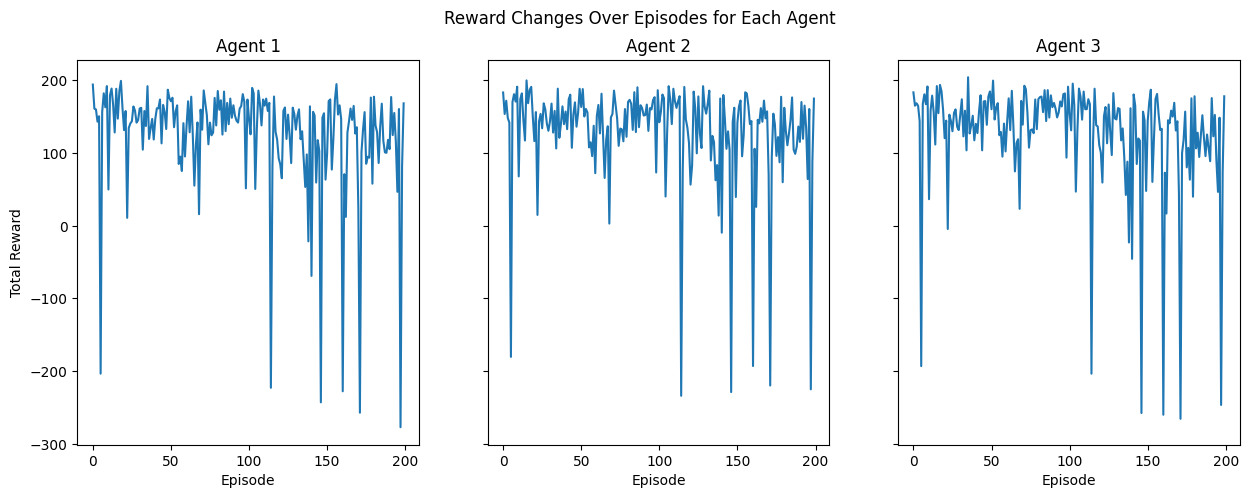

In [3]:
# Initialize environment
env = MultiAgentSweepingEnv()

# Initialize three agents with shared grid information
agents = [Agent(grid_size=env.grid_size, output_dim=env.action_space.n) for _ in range(env.n_agents)]
episodes = 200
batch_size = 32
agent_rewards = np.zeros((env.n_agents, episodes))  # Track rewards for each agent
agent_moves = np.zeros(env.n_agents)  # Track moves for each agent
max_moves = 500  # Set the maximum moves per episode

best_total_reward = -float('inf')
best_episode = 0
best_agent_rewards = None
best_agent_moves = None

for e in range(episodes):
    state = env.reset()
    done = False
    total_rewards = np.zeros(env.n_agents)
    agent_moves.fill(0)  # Reset move counters for this episode

    while not done and np.max(agent_moves) < max_moves:
        actions = []
        for i, agent in enumerate(agents):
            state_input = state.flatten()  # Flatten the 3D grid state to a 1D array
            action = agent.act(state_input)
            actions.append(action)

        next_state, rewards, done, _ = env.step(actions)

        for i, agent in enumerate(agents):
            state_input = state.flatten()
            next_state_input = next_state.flatten()
            agent.remember(state_input, actions[i], rewards[i], next_state_input, done)
            total_rewards[i] += rewards[i]
            agent_moves[i] += 1  # Increment the move counter for this agent

        state = next_state

        for agent in agents:
            agent.replay(batch_size)

    total_episode_reward = np.sum(total_rewards)
    if total_episode_reward > best_total_reward:
        best_total_reward = total_episode_reward
        best_episode = e + 1
        best_agent_rewards = total_rewards.copy()
        best_agent_moves = agent_moves.copy()

    agent_rewards[:, e] = total_rewards  # Store the total rewards for each agent in this episode
    print(f"Episode {e + 1}/{episodes}, Total Rewards: {total_rewards}, Moves: {agent_moves}")
    env.render()

# Print the best episode results
print("\nBest Episode Results:")
print(f"Best Episode: {best_episode}")
print(f"Best Total Reward: {best_total_reward}")
print(f"Agent Rewards in Best Episode: {best_agent_rewards}")
print(f"Agent Moves in Best Episode: {best_agent_moves}")

# Plotting the reward changes over episodes for each agent
fig, axes = plt.subplots(1, env.n_agents, figsize=(15, 5), sharey=True)

for i in range(env.n_agents):
    axes[i].plot(agent_rewards[i])
    axes[i].set_title(f'Agent {i+1}')
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Total Reward')

plt.suptitle('Reward Changes Over Episodes for Each Agent')
plt.show()
